# Rays, a Simple Camera, and Background

In [ ]:
import os
import math
import numpy as np
import cupy as cp

from util_cuda import upload_constant
from display_image import write_and_display

dn = os.path.join(os.path.dirname(os.getcwd()), 'kernels')
fnl = list()
fnl.append(os.path.join(dn, 'vec3.cuh'))
fnl.append(os.path.join(dn, 'ray.cuh'))
fnl.append(os.path.join(dn, 'render.cu'))

cuda_source = None
for fpfn in fnl:
    with open(fpfn, 'r') as f:
        cs = f.read()
    if cuda_source is None:
        cuda_source = cs
    else:
        cuda_source += cs

In [ ]:
aspect_ratio = 16.0 / 9.0
image_width = int(400)
image_height = int(image_width / aspect_ratio)
image_height = max(1, image_height)

cuda_source = cuda_source.replace('RTOW_WIDTH', str(image_width))
cuda_source = cuda_source.replace('RTOW_HEIGHT', str(image_height))

module = cp.RawModule(code=cuda_source)
module.compile()

In [ ]:
focal_length = 1.0
viewport_height = 2.0
viewport_width = viewport_height * (float(image_width)/image_height)
camera_center = np.array([0, 0, 0], dtype=np.float32)

viewport_u = np.array([viewport_width, 0, 0], dtype=np.float32)
viewport_v = np.array([0, -viewport_height, 0], dtype=np.float32)

pixel_delta_u = viewport_u / image_width
pixel_delta_v = viewport_v / image_height

viewport_upper_left = camera_center - np.array([0, 0, focal_length], dtype=np.float32) - viewport_u/2 - viewport_v/2
pixel00_loc = viewport_upper_left + 0.5 * (pixel_delta_u + pixel_delta_v)

upload_constant(module, camera_center, 'g_cameraCenter')
upload_constant(module, pixel_delta_u, 'g_pixelDeltaU')
upload_constant(module, pixel_delta_v, 'g_pixelDeltaV')
upload_constant(module, pixel00_loc, 'g_pixel00Loc')

In [ ]:
img_gpu = cp.empty((image_height, image_width, 3), dtype=cp.float32)
assert img_gpu.flags.c_contiguous

gpu_func = module.get_function('render')
sz_block = 32, 32
sz_grid = math.ceil(image_width / sz_block[1]), math.ceil(image_height / sz_block[0])
gpu_func(
  block=sz_block, grid=sz_grid,
  args=(img_gpu)
)
cp.cuda.runtime.deviceSynchronize()

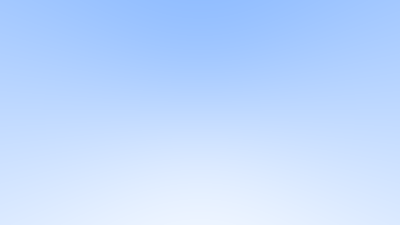

In [ ]:
img = img_gpu.get()
img8 = (img * np.float32(255.99)).astype(np.uint8)

write_and_display(img8)